# Catatan Cakrawala Notebook - BDC Satria Data
### Author :
* Dimas Kuncoro Jati
* Muhammad Amanda
* Wahyu Setianto

### Note :
Seluruh kode dapat diakses melalui responsitory kami [di sini](https://github.com/Hyuto/BDC-Satria-Data)

# BDC - Satria Data 2020
DAFTAR ISI TAMBAHINNN


## Task
Mendeteksi apakah sutau berita adalah hoax atau tidak (`Binary Classification`).

## Data
* Data Gambar
* Data Text (judul dan narasi berita)

## First Things First
* Load Library
* Global SEED-ing
* Keeping Google Cloud Storage PATH

In [1]:
# Imports
import os, random, re, string, emoji
from timeit import default_timer
from tqdm.notebook import tqdm

# Kaggle Datasets for checking GCS
from kaggle_datasets import KaggleDatasets

# Scientific tools
import numpy as np
import pandas as pd

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-notebook")

# Interactive 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Image processing
from PIL import Image
from skimage.transform import rotate

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Scikit Learn
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.feature_extraction.text import CountVectorizer

print(f'Using Tensorflow Version       : {tf.__version__}')

# SEED ALL
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = str(SEED)
tf.random.set_seed(SEED)

# GCS PATH
GCS_PATH = KaggleDatasets().get_gcs_path('data-bdc')
print(f'Google Cloud Storage Data Path : {GCS_PATH}')

Using Tensorflow Version       : 2.3.0
Google Cloud Storage Data Path : gs://kds-a42c4c3e32eed6c3af9d1d2125e9edf0bcce7c2a3c1e3f38f8080d29


# 1. Preprocessing Data
Melakukan preprocessing data sebelum diolah

### Load Dataset
Load dataset ke memmory

In [2]:
train = pd.read_excel('../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/Data Latih BDC.xlsx')
test = pd.read_excel('../input/data-bdc/Data BDC - Satria Data 2020/Data Uji/Data Uji BDC.xlsx')
train.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,2020-08-17 00:00:00,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,2020-07-17 00:00:00,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,2020-07-13 00:00:00,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,2020-07-08 00:00:00,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,2020-06-24 00:00:00,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


## Download Fungsi Tambahan
Mendownload fungsi yang sudah dibuat dari responsitory kami.

In [3]:
!wget -q https://raw.githubusercontent.com/Hyuto/BDC-Satria-Data/master/Preprocess%20code/RPU.py
!wget -q https://raw.githubusercontent.com/Hyuto/BDC-Satria-Data/master/Preprocess%20code/Preprocess.py

## Data Gambar
Melakukan preprocessing pada data gambar

### Sesuaikan Path data gambar
Menyesuaikan direktori data gambar

In [4]:
# Train & Test Image PATH
TRAIN_PATH = '../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/File Gambar Data Latih/'
TEST_PATH = '../input/data-bdc/Data BDC - Satria Data 2020/Data Uji/File Gambar Data Uji/'

tambahkan Path ke nama file gambar

In [5]:
# Apply to nama file
TRAIN_IMG = [TRAIN_PATH + x for x in train['nama file gambar'].values]
TEST_IMG = [TEST_PATH + x for x in test['nama file gambar'].values]

## Checking Missing Data
Mengecek apakah ada data yang hilang / tidak bisa terbaca pada direktori gambar.

In [6]:
def check_missing(files, return_missing_ID = True):
    """
    Mengecek keberadaan data gambar berdasarkan direktori
    """
    missing = []
    for file in files:
        if not os.path.isfile(file):
            missing.append(file)
    print(f'[INFO] Missing {len(missing)} file')
    if return_missing_ID:
        return sorted([int(x.split('/')[-1][:-4]) for x in missing])

In [7]:
# Missing pada data TRAIN
missing_train = check_missing(TRAIN_IMG)
missing_train

[INFO] Missing 9 file


[48121, 275477, 343052, 367583, 555990, 697754, 697955, 742855, 743885]

In [8]:
# Missing pada data TEST
missing_test = check_missing(TEST_IMG)
missing_test

[INFO] Missing 2 file


[690192, 693499]

Terdapat 9 file gambar pada data train dan 2 file gambar pada data test yang hilang. Hal ini di duga karena nama file berbeda pada direktori gambar dan pada dataframe. Maka dari itu kami melakukan pengecekan nama file pada direktori gambar dengan menyamakan `ID`-nya.

In [9]:
def fixing_extensions(missing, path):
    """
    Membenarkan ekstensi file gambar yang di anggap hilang
    dari direktori.
    """
    res = []
    for miss in missing:
        fixed = False
        list_dir = os.listdir(path)
        for i in range(len(list_dir)):
            if miss == int(list_dir[i][:-4]):
                fixed = True
                res.append((miss, list_dir[i]))
                break
        if not fixed:
            res.append((miss, '404')) # Not Found
    return res

In [10]:
# Apply function
fixed_missing_train = fixing_extensions(missing_train, TRAIN_PATH)
fixed_missing_test = fixing_extensions(missing_test, TEST_PATH)

Setelah nama file yang hilang dibenarkan, apply nama file yang benar ke main dataframe.

In [11]:
# Apply to train DF
for Id, filename in fixed_missing_train:
    index = train.ID.tolist().index(Id)
    train.loc[index, 'nama file gambar'] = filename

# Apply to test DF
for Id, filename in fixed_missing_test:
    index = test.ID.tolist().index(Id)
    test.loc[index, 'nama file gambar'] = filename

Spesifikasi ulang nama file gambar

In [12]:
TRAIN_X = [TRAIN_PATH + x for x in train['nama file gambar'].values if x != '404']
TRAIN_y = train.label.values

### Mengecek Data Gambar
Mengecek data gambar yang ada

In [13]:
def read_and_resize(path):
    """
    Read & Resize data gambar
    """
    img = Image.open(path)
    img.resize((256, 256), Image.ANTIALIAS)
    return img

def show_images(list_dir, label, load_image = read_and_resize, seed = SEED):
    """
    Menampilkan Gambar Secara acak berdasarkan kelasnya 
    masing - masing sebanyak 5 buah.
    """
    random.seed(seed)
    data_0 = random.sample([x for x in zip(list_dir, label) if x[1] == 0], 5)
    data_1 = random.sample([x for x in zip(list_dir, label) if x[1] == 1], 5)
    fig, axes = plt.subplots(2, 5, figsize = (20, 10))
    for i in range(2):
        if i == 0:
            data = data_0
        else:
            data = data_1
        for j in range(5):
            img = load_image(data[j][0])
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'Label : {data[j][1]}', fontsize = 14)
            axes[i, j].axis('off')
    fig.tight_layout()
    plt.show()

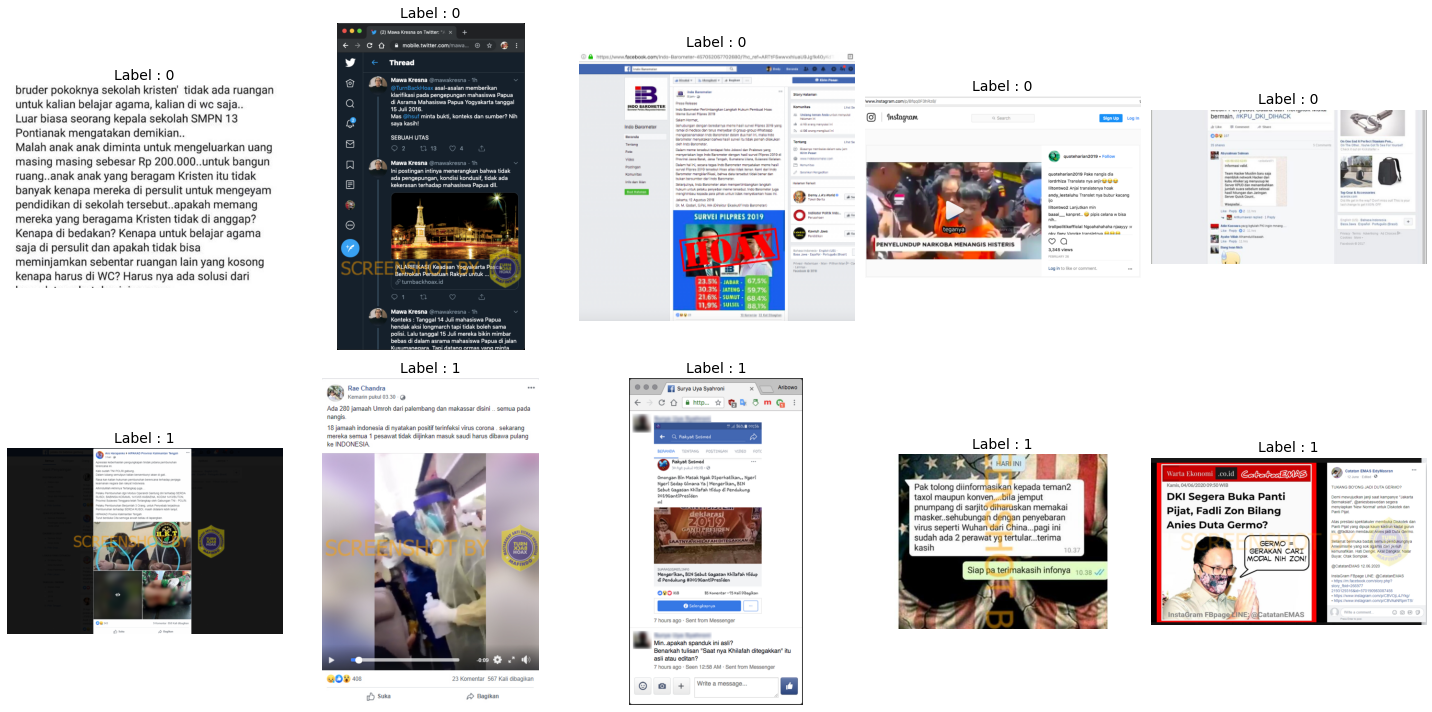

In [14]:
show_images(TRAIN_X, TRAIN_y)

Dapat dilihat gambar meiliki ukuran & orientasi yang berbeda - beda. 

Untuk mengatasi hal ini diambil sample posisi `center` pada gambar dan `meresize gambar` tersebut ke ukuran yang di tetapkan.

In [15]:
def load_and_preprocess_image(path: str, size = [256, 256]):
    """
    Load & Preprocess data gambar
    """
    image = img_to_array(load_img(path))
    img = tf.convert_to_tensor(image, dtype=tf.float32)
    shapes = tf.shape(img)
    h, w = shapes[-3], shapes[-2]
    dim = tf.minimum(h, w)
    img = tf.image.resize_with_crop_or_pad(img, dim, dim)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

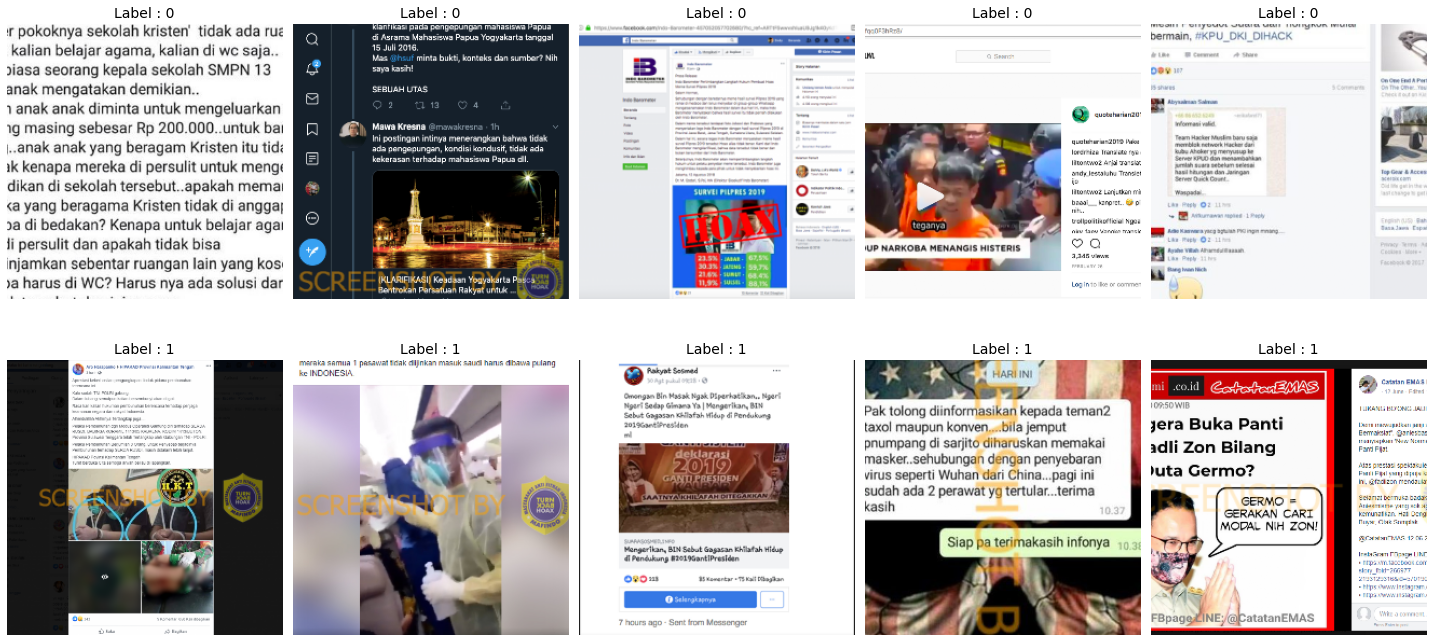

In [16]:
show_images(TRAIN_X, TRAIN_y, load_and_preprocess_image)

### Image Augmentation
Karena data gambar belum cukup banyak, data tersebut bisa di lipat gandakan dengan melakukan augmentasi.

Augmentasi yang digunakan yaitu.
```
Rotasi Acak dengan nilai rotasi di random pada kisaran -70 sd 70 derajad
```

In [17]:
data_augmentation = lambda x : (
    rotate(x, random.randint(-70, 70), mode='reflect')
)

Mengecek fungsi augmentasi

In [18]:
def AUG_test(X):
    """
    Plot gambar dengan fungsi Augmentasi
    """
    X = load_and_preprocess_image(X)
    fig, axes = plt.subplots(1, 5, figsize = (20,10))
    axes[0].imshow(X)
    axes[0].set_title('Actual', fontsize = 14)
    axes[0].axis('off')
    for i in range(1, 5):
        aug = data_augmentation(X)
        axes[i].imshow(aug)
        axes[i].set_title('Augmented', fontsize = 14)
        axes[i].axis('off')
    fig.tight_layout()
    return plt.show()

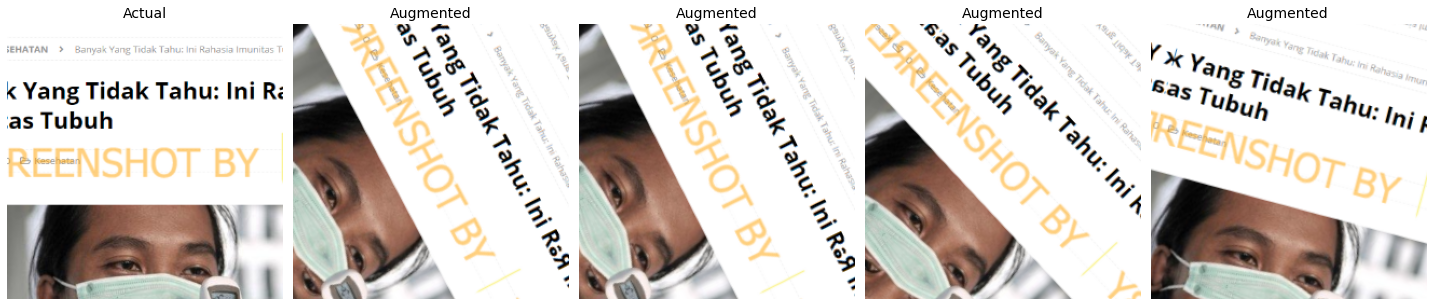

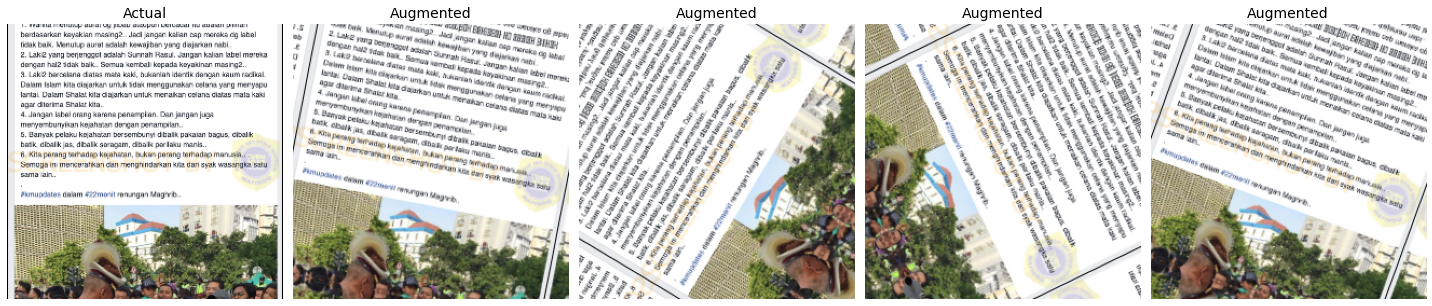

In [19]:
for i in random.sample(TRAIN_X, 2):
    AUG_test(i)

### Up Sampling Data
Mengapply Preprocess & Augmentasi ke data gambar dan menyimpan gambar pada direktori baru.
Menggunakan Fungsi tambahan yang sudah di download pada file `RPU.py`

Fungsi akan mengembalikan List direktori gambar dan juga labelnya.

`ApplyAUG -> IMAGE_DIR, Label`

Contoh Penggunaan
```
from RPU import ApplyAUG

TRAIN_X, TRAIN_y = (
       ApplyAUG(TRAIN_X,               # List atau Array direktori dari gambar
                TRAIN_y,               # List atau Array kelas(label) dari TRAIN_X [One Hot Encoding]
                PATH,                  # Direktori data gambar
                up_sample_ratio = 1,   # Rasio Up Sample
                up_sample_class = '0', # Spesifikasi Class yang akan di Up Sample  
                data_aug = data_augmentation,  # Fungsi Augmentasi
                LP = load_and_preprocess_image # Fungsi Load & Preprocess
                )
)
```
Atau bisa juga menggunakan shell
```
!python RPU.py PATH SIZE TEST_SIZE UP_SAMPLES UP_SAMPLE_CLASS
```
Namun pada kernel ini tidak akan di gunakan fungsi tersebut. Melaikan menggunakan hasil dari fungsi tersebut, karena kernel ini di run pada TPU & TPU tidak dapat membaca diluar dari `GCS` (lokal direktori).

Note : Up Sample data pada Notebook ini didapatkan dengan command berikut
```
!python RPU.py '../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/File Gambar Data Latih/' \
                SIZE:512 TEST_SIZE:0.15 UP_SAMPLES:0.5-1-2 UP_SAMPLE_CLASS:0
```

## Data Text
Melakukan preprocessing pada data text. Load fungsi pada file `Preprocess.py` terlebih dahulu

In [20]:
from Preprocess import *

Pada notebook ini pengolahan data text dilakukan menggunakan `judul` dan `narasi`, sehingga perlu dilakukan penyatuan kolom `judul` dan kolom `narasi`.

In [21]:
train['text'] = (train['judul'] + ' ' + train['narasi']).apply(lambda x : x.lower())
test['text'] = (test['judul'] + ' ' + test['narasi']).apply(lambda x : x.lower())
train.head()

,ID,label,tanggal,judul,narasi,nama file gambar,text
0,71,1,2020-08-17 00:00:00,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg,pemakaian masker menyebabkan penyakit legionna...
1,461,1,2020-07-17 00:00:00,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png,instruksi gubernur jateng tentang penilangan ...
2,495,1,2020-07-13 00:00:00,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png,foto jim rohn: jokowi adalah presiden terbaik ...
3,550,1,2020-07-08 00:00:00,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png,"ini bukan politik, tapi kenyataan pak jokowi b..."
4,681,1,2020-06-24 00:00:00,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg,foto kadrun kalo lihat foto ini panas dingin k...


### Mengecek Duplicated Values
Mengecek keberadaan data yang berduplikasi.

In [22]:
train[train.duplicated(subset=['text'], keep=False)]

,ID,label,tanggal,judul,narasi,nama file gambar,text
559,130974,0,2015-11-28 00:00:00,Jokowi Lebih Memilih Helikopter Buatan Luar Ne...,"INSTING MAKELAR\n \n AKU Awalnya kaget, membac...",130974.png,jokowi lebih memilih helikopter buatan luar ne...
604,140123,1,2020-06-02 00:00:00,Foto Sekarang malesiya sapu habis penduduk asi...,Perhatian perhatian Sekarang malesiya makin da...,140123.jpg,foto sekarang malesiya sapu habis penduduk asi...
812,188319,0,2015-11-28 00:00:00,Jokowi Lebih Memilih Helikopter Buatan Luar Ne...,"INSTING MAKELAR\n \n AKU Awalnya kaget, membac...",188319.png,jokowi lebih memilih helikopter buatan luar ne...
1344,312152,1,2020-06-02 00:00:00,Foto Sekarang malesiya sapu habis penduduk asi...,Perhatian perhatian Sekarang malesiya makin da...,312152.jpg,foto sekarang malesiya sapu habis penduduk asi...
3824,898927,1,2018-03-12 00:00:00,Soal Bocornya NIK dan Nomor KK Sekarang dilemp...,Siapa yang disalahkan ?\n Saling lempar tanggu...,898927.jpg,soal bocornya nik dan nomor kk sekarang dilemp...
3927,923503,1,2018-03-12 00:00:00,Soal Bocornya NIK dan Nomor KK Sekarang dilemp...,Siapa yang disalahkan ?\n Saling lempar tanggu...,923503.png,soal bocornya nik dan nomor kk sekarang dilemp...


Mendrop data yang berduplikasi

In [23]:
# Drop duplicates row
train = train.drop_duplicates(subset ="text").reset_index()

In [24]:
def clean_up(arr):
    r"""
    Cleanup \n and lowering text
    """
    for i in range(len(arr)):
        arr[i] = arr[i].lower()
        arr[i] = re.sub('\n', ' ', arr[i])
        arr[i] = ' '.join(arr[i].split())
    return arr

In [25]:
# Init text
train_text = clean_up(train.text.values)
test_text = clean_up(test.text.values)

### Mengekstrack Feature dari Text
Mengekstrack feature seperti `URL`, `Hashtag`, `Tag`, dan `Emoji` dari text untuk melihat informasi dan frekuensi kemunculannya dalam setiap kelas pada data

In [26]:
%%time
FE = FeatureExtraction()
FE_test = FeatureExtraction()
FE.fit(train_text, train.label.values)
FE_test.fit(test_text)

CPU times: user 7.3 s, sys: 1.19 ms, total: 7.3 s
Wall time: 7.3 s


In [27]:
FE.get_table('urls', return_prop = True)

,urls,0,1,frekuensi,max_prop
0,kompas.com,0.333333,0.666667,3,0.666667
1,viva.co.id,0.000000,1.000000,2,1.000000
2,seword.com,0.500000,0.500000,2,0.500000
3,opishposh.com,0.500000,0.500000,2,0.500000
4,https://t.co/jvjxc0jhmp,0.000000,1.000000,1,1.000000
...,...,...,...,...,...
80,http://poskotanews.com/…/pa-212-batalkan-acara...,0.000000,1.000000,1,1.000000
81,www.piyunganonline.co,0.000000,1.000000,1,1.000000
82,https://goo.gl/2xz5yn,0.000000,1.000000,1,1.000000
83,corona-virus-map.com.exe.,1.000000,0.000000,1,1.000000


In [28]:
FE.get_table('hashtags', return_prop = True)

,hashtags,0,1,frekuensi,max_prop
0,#2019gantipresiden,0.133333,0.866667,15,0.866667
1,#covid19,0.000000,1.000000,5,1.000000
2,#2019,0.000000,1.000000,4,1.000000
3,#coronavirus,0.000000,1.000000,3,1.000000
4,#stayhome,0.000000,1.000000,3,1.000000
...,...,...,...,...,...
351,#sekolahnews,0.000000,1.000000,1,1.000000
352,#wkwkland,0.000000,1.000000,1,1.000000
353,#abusendal,0.000000,1.000000,1,1.000000
354,#sayapancasila,1.000000,0.000000,1,1.000000


In [29]:
FE.get_table('tags', return_prop = True)

,tags,0,1,frekuensi,max_prop
0,@jokowi,0.111111,0.888889,9,0.888889
1,@aniesbaswedan,0.000000,1.000000,6,1.000000
2,@prabowo,0.166667,0.833333,6,0.833333
3,@fadlizon,0.200000,0.800000,5,0.800000
4,@netizentofa,0.000000,1.000000,2,1.000000
...,...,...,...,...,...
142,@kemenhub151,0.000000,1.000000,1,1.000000
143,@ricky_hf,0.000000,1.000000,1,1.000000
144,@kai121,0.000000,1.000000,1,1.000000
145,@ankertwiter,0.000000,1.000000,1,1.000000


In [30]:
FE.get_table('emojis', return_prop = True)

,emojis,0,1,frekuensi,max_prop
0,😂,0.076923,0.923077,13,0.923077
1,😭,0.142857,0.857143,7,0.857143
2,🙏,0.285714,0.714286,7,0.714286
3,😢,0.166667,0.833333,6,0.833333
4,😍,0.000000,1.000000,5,1.000000
...,...,...,...,...,...
67,🇲🇨,0.000000,1.000000,1,1.000000
68,⏬,0.000000,1.000000,1,1.000000
69,😛,0.000000,1.000000,1,1.000000
70,😟,0.000000,1.000000,1,1.000000


Karena ukuran data yang cukup kecil dan sepertinya setiap feature memiliki informasi yang cukup berpengaruh terhadap kelasnya, kami memutuskan untuk tidak menghapus satupun feature yang ada.

### Masking Feature (Encode)
Masking feature pada text. Feauture yang sudah di `.fit` pada data sebelumnya, proses ini dilakukan karena pada feature ini terdapat peletakan tanda baca yang random / tidak beraturan, sedangkan pada proses berikutnya akan dilakukan penormalisasian tanda baca sehingga akan mengganggu proses tersebut. Maka dari itu perlu dilakukan masking agar proses normalisasi kalimat berjalan dengan lancar.
```
# Contoh
Website Statistika UNJ adalah http://fmipa.unj.ac.id/statistika/
BEM Statistika UNJ #AltairBergerakMengukir
@jokowi adalah presiden RI
Lucu 😂

# Encode
Website Statistika UNJ adalah MASKURLS1MASK
BEM Statistika UNJ MASKHASHTAGS1MASK
MASKTAGS1MASK adalah presiden RI
Lucu MASKEMOJIS1MASK
```

In [31]:
# Build Mask Code
FE.build_mask_code(0)
FE_test.build_mask_code(0)
# Apply to data
train_text = FE.encode(train_text)    # Train
test_text = FE_test.encode(test_text) # Test

### Normalisasi Tanda Baca
Melakukan normalisasi tanda baca pada text. Karena banyak peletakan tanda baca yang salah pada text yang akan mengganggu `tokenizer` dalam melakukan segmentasi pada kalimat.
```
# Contoh
Budi membayar2.000 ban yang dibelinya senilai rp.2.000.000

# Preprocessed
Budi membayar 2.000 ban yang dibelinya senilai rp. 2.000.000
```

In [32]:
def normalize(array):
    """
    Normalize text
    """
    punc, arr = string.punctuation, array.copy()
    for i in range(len(arr)):
        temp = list(arr[i])
        for j in range(1, len(temp) - 1):
            if (temp[j] in punc) and not\
            all([x in string.digits for x in [temp[j-1], temp[j+1]]]):
                temp[j] = ' ' + temp[j] + ' '
            elif (temp[j] in string.ascii_lowercase) and (temp[j + 1] \
            in string.digits or temp[j + 1] in string.punctuation):
                temp[j] += ' '
        arr[i] = ''.join(temp)
        arr[i] = ' '.join(arr[i].split())
    return arr

In [33]:
# Apply to text
train_text = normalize(train_text) # Train
test_text = normalize(test_text)   # Test

### Decode & Menghapus Tanda Baca
Men-Decode (mengembalikan feature) serta menghapus tanda baca yang ada pada text.
```
# Contoh
Website Statistika UNJ adalah MASKURLS1MASK

# Decode
Website Statistika UNJ adalah http://fmipa.unj.ac.id/statistika/

# Remove Punctuation
Website Statistika UNJ adalah httpfmipaunjacidstatistika
```

In [34]:
# Add more string punctuation
string.punctuation += '‘’…“”–'

In [35]:
def remove_punc(arr, punc_):
    """
    Remove string punctuation
    """
    return asarray([x.translate(str.maketrans('', '', punc_))
                    for x in arr])

In [36]:
# Apply to data
train_text = FE.decode(train_text)    # Train
train_text = remove_punc(train_text, string.punctuation)
test_text = FE_test.decode(test_text) # Test
test_text = remove_punc(test_text, string.punctuation)

### De-Emijized
Mengubah kode emoji yang ada pada text menjadi kata kata yang dapat dimengerti.
```
🙏 -> folded hands
😃 -> grinning face with big eyes
```

In [37]:
def deemojized(arr):
    """
    De Emojized text
    """
    for i in range(len(arr)):
        arr[i] = emoji.demojize(arr[i])
        arr[i] = re.sub(':', ' ', arr[i])
        arr[i] = re.sub('_', ' ', arr[i])
        arr[i] = ' '.join(arr[i].split())
    return arr

In [38]:
# Apply to data
train_text = deemojized(train_text) # Train
test_text = deemojized(test_text)   # Test

### Mengecek Kata yang Misspell (typo)
Mengecek kata-kata yang misspell atau typo serta kata - kata singkatan. 

1. Membangun Vocabulary<br>
Membangun Vocabulary dari data untuk di cek secara **Manual**

In [39]:
# Count Vectorizer
count = CountVectorizer()
count.fit(train_text)

CountVectorizer()

In [40]:
# Vocabulary to DataFrame
vocab = pd.DataFrame({'Vocab' : list(count.vocabulary_.keys()), 
                     'Frekuensi' : list(count.vocabulary_.values())})
vocab = vocab.sort_values(by=['Frekuensi'], ascending = False)
vocab[:30].style.hide_index()

Vocab,Frekuensi
ﾟﾏﾻ,20166
加油jiayou,20165
হয়,20164
সল,20163
সব,20162
নম,20161
নব,20160
ধন,20159
চলছ,20158
কখ,20157


Dapat dilihat dari tabel diatas bahwa data terdiri dari beberapa bahasa karena terdapat banyak kata yang bukan berasal dari bahasa Indonesia seperti `ﾟﾏﾻ`, `加油jiayou`, `হয়`, `সল`, dll.

2. Mengeksport Vocabulary <br>
Mengeksport vocabulary telah dibangun kedalam file `.txt` untuk dapat dilakukan pengecekan secara manual terhadap kata-kata tersebut.
```
f = open("vocab.txt", "w")
f.write(" \n".join(sorted(vocab.Vocab.values)))
f.close()
```

Selanjutnya, mengimport file yang berisi kata - kata yang telah di cek secara manual lalu mengapikasikannya pada data text menggunakan kelas `SpellChecker`, fitting didapat dilakukan pada file yang diinginkan atau dapat menggunakan file yang telah di benarkan oleh tim Catatan Cakrawala dengan mengisikan `cc-hand-fixed` pada saat fitting class.

In [41]:
spellchecker = SpellChecker()
spellchecker.fit('cc-hand-fixed')

`Transform` untuk apply pada data.

In [42]:
# Apply to Data
train_text = spellchecker.transform(train_text) # Train
test_text = spellchecker.transform(test_text)   # Test

### Memhapus Kata yang Kurang Penting & Stopwords
Menghapus kata - kata yang kurang penting seperti kata yang hanya terdiri dari 1 karakter dan Stopwords. Untuk Stopwords kami menggabungkan stopwords bahasa Indonesia dari `Spacy` dan `Sastrawi` serta bahasa Inggris dari `Spacy`.

In [43]:
!pip -q install sastrawi # Install Santrawi

from spacy.lang.id.stop_words import STOP_WORDS as ID
from spacy.lang.en.stop_words import STOP_WORDS as EN
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stopwords = set(StopWordRemoverFactory().get_stop_words())
stopwords.update(EN)
stopwords.update(ID)

In [44]:
def RUnecesarry(array, stopwords):
    """
    Remove Unnecessary words
    """
    arr = array.copy()
    for i in range(len(arr)):
        temp = arr[i].split()
        temp = [x for x in temp if not (len(x) == 1 and \
                (x in string.ascii_lowercase or x in string.digits))]
        temp = [x for x in temp if x not in stopwords]
        arr[i] = ' '.join(temp).lower()
    return arr

In [45]:
# Apply to data
train_text = RUnecesarry(train_text, stopwords) # Train
test_text = RUnecesarry(test_text, stopwords)   # Test

Mengecek hasil dari tahap preprocess data text

In [46]:
for i in [0, 803, 1002]:
    print(f"Actual : \n{train.text.values[i]}\n\nPreprocessed : \n{train_text[i]}")
    print(''.rjust(80, '-'))

Actual : 
pemakaian masker menyebabkan penyakit legionnaires a caller to a radio talk show recently shared that his wife was hospitalized n told she had covid n only a couple of days left to live . a doctor friend suggested she be tested for legionnaires disease because she wore the same mask every day all day long . turns out it was legionnaires disease from the moisture n bacteria in her mask . she was given antibiotics n within two days was better . what if these ‘spikes’ in covid are really something else due to ‘mask induced infections’ .??🤔🤔🤔

Preprocessed : 
pemakaian masker menyebabkan penyakit legionnaires caller radio talk recently shared wife hospitalized told covid couple days left live doctor friend suggested tested legionnaires disease wore mask day day long turns legionnaires disease moisture bacteria mask given antibiotics days better spikes covid mask induced infections thinking face thinking face thinking face
----------------------------------------------------------

# Explorasi Data
Melakukan explorasi pada data untuk mendapatkan informasi - informasi lebih jauh dari data.

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228 entries, 0 to 4227
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             4228 non-null   int64 
 1   ID                4228 non-null   int64 
 2   label             4228 non-null   int64 
 3   tanggal           4228 non-null   object
 4   judul             4228 non-null   object
 5   narasi            4228 non-null   object
 6   nama file gambar  4228 non-null   object
 7   text              4228 non-null   object
dtypes: int64(3), object(5)
memory usage: 264.4+ KB


Merubah tipe pada kolom tanggal menjadi `datetime`. Kolom tanggal tidak dapat langsung dirubah tipe datanya menjadi `datetime` dikarenakan ada nya beberapa element yang mengandung kata `Okt` dan `Agu` sehingga harus diubah menjadi `Oct` dan `Aug`

In [48]:
def FixMonth(text):
    """
    Fungsi untuk merubah kata 'Okt' menjadi 'Oct' dan 'Agu' menjadi 'Aug'
    """
    if type(text) == str:
        if 'Okt' in text: return text[:3]+'Oct'+text[6:]
        else: return text[:3]+'Aug'+text[6:]
    else:
        return text

In [49]:
# Apply to data
train['tanggal'] = train['tanggal'].apply(FixMonth)
train['tanggal'] = pd.to_datetime(train['tanggal'])

## Mengecek Frekuensi Setiap Kelas
Menegecek frekuensi tiap kelasnya pada data.

In [50]:
fig_1 = go.Figure(go.Pie(labels=['Bukan Hoax', 'Hoax'],
                       values=train.groupby('label').size().values, 
                       textinfo='percent+label+value', 
                       textfont_color='#ffffff', 
                       marker_colors=['#0db7c5','#d03850'])
               )
fig_1.update_layout(
    title={
        'text': "Frekuensi Perkelasnya",
        'y':0.93,
        'x':0.5,
        'font_size':23},
    width=550, height=550
)

fig_1.show()

Dapat dilihat bahwa kelas 1 (`Hoax`) jauh lebih banyak dari kelas 0 (`Bukan Hoax`) terdapat `imbalance class` pada data. Untuk penanganannya sendiri pada notebook ini kami melakukan `Stratify` saat melakukan `Cross Validation` sehingga proporsi pada subset `latih` dan pada subset `validasi` sama.

## Melihat Sebaran Kelas per Waktunya
Melihat sebaran kelas perwaktunya.
1. Membuat kolom baru untuk menyimpan tahun & bulan
1. Mengelompokkan

In [51]:
# Membuat Kolom baru untuk menyimpan nilai tahun dan bulan
train['year'] = [i.year for i in train.tanggal]
train['month'] = [i.month for i in train.tanggal]
# Grouping 
data_waktu = (train.groupby(['year', 'month', 'label']).size().reset_index()
              .pivot(columns='label', index=['year','month'], values=0))

Plotting

In [52]:
fig_2 = go.Figure(data=[ 
    go.Bar(name='Bukan Hoax', 
           x=[str(i) for i in data_waktu.index], 
           y=data_waktu[0].values, 
           marker_color='#0db7c5'),
    go.Bar(name='Hoax',
           x=[str(i) for i in data_waktu.index], 
           y=data_waktu[1].values, 
           marker_color='#d03850')
])

fig_2.update_layout(barmode='stack', 
                  xaxis=dict(dtick=1,
                             showgrid=False, 
                             title='(Tahun, Bulan)'),
                  legend=dict(x=0.006,y=0.97, 
                              bgcolor='rgba(255,255,255,0)', 
                              bordercolor='rgba(0,0,0,0)',
                              font_color='#090919',
                              font_size=14),
                  title=dict(text='Sebaran Hoax per Waktu',
                             x=0.5,
                             y=0.9,
                             font_size=23),
                  width=1000,height=550
                 )

fig_2.show()

Insight
2019 - pilpress
2020 - corona

### Mengecek Kata - Kata yang Muncul Perkelasnya
Mengecek frekuensi kata - kata yang muncul berdasarkan kelasnya.

In [53]:
def find_words(texts, label, builder = CountVectorizer(min_df=3, max_df=0.9,
                                                       ngram_range=(1,2))):
    """
    Memeriksa kalimat berdasarkan kelasnya untuk membuat vocab
    """
    builder.fit(texts)
    n_class, res = len(set(label)), {}
    for i in tqdm(range(len(texts))):
        for vocab in texts[i].split():
            if vocab in builder.vocabulary_:
                if vocab not in res:
                    res[vocab] = [0] * n_class + [0]
                res[vocab][label[i]] += 1
                res[vocab][-1] += 1
    df = pd.DataFrame({'kata' : list(res.keys())})
    for i in range(n_class):
        df[f'Kelas_{i}'] = [res[x][i] for x in res]
    df['Frekuensi'] = [res[x][-1] for x in res]
    return df.sort_values(by = ['Frekuensi'], ascending = False).reset_index(drop=True)

In [54]:
# Vocab DF per class
words = find_words(train_text, train.label.values)
words['Max_prop'] = words[['Kelas_0', 'Kelas_1']].max(axis = 1) / words['Frekuensi']

Plotting scatter dengan `x` adalah frekuensi kemunculan kata dan `y` adalah proporsi frekuensi untuk kelas terkait.

Berikut adalah plot scatter untuk kata - kata pada kelas `1` yang mempunyai frekuensi kumunculan lebih dari kelas `0` dan mempunyai proporsi lebih dari `0.8`

In [ ]:
_1 = words[(words['Kelas_1'] > words['Kelas_0']) & (words['Max_prop'] > 0.8)]
_1.head(10)

In [57]:
fig_3 = px.scatter(_1, x="Frekuensi", y="Max_prop",
	         size="Kelas_1", hover_name="kata", size_max=30)

fig_3.update_layout(yaxis=dict(title='Proporsi Pada Kelas 1'),
                    title=dict(text='Frekuensi Kata - Kata pada Kelas 1',
                             x=0.5, y=0.95, font_size=23),
                  width=1000,height=550,
)
fig_3.show()

Berikut adalah plot scatter untuk kata - kata pada kelas `0` yang mempunyai frekuensi kumunculan lebih dari kelas `1` dan mempunyai proporsi lebih dari `0.8`

In [ ]:
_0 = words[(words['Kelas_0'] > words['Kelas_1']) & (words['Max_prop'] > 0.8)]
_0.head(10)

In [58]:
fig_4 = px.scatter(_0, x="Frekuensi", y="Max_prop",
	         size="Kelas_0", hover_name="kata", size_max=20)

fig_4.update_layout(yaxis=dict(title='Proporsi Pada Kelas 0'),
                    title=dict(text='Frekuensi Kata - Kata pada Kelas 0',
                               x=0.5, y=0.95, font_size=23),
                  width=1000,height=550
)
fig_4.show()

# Modeling
Membuat model untuk memprediksi kelas `0` dan kelas `1` pada data test

## Model untuk Data Gambar
Model yang digunakan untuk data gambar yaitu pretrained Deep Learning model yang cukup popular yaitu `EfficientNet`. `EfficientNet` digunakan karena kemampuannya yang cukup mengesankan dalam mengklasifikasi data gambar pada `ImageNet`.
<img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" alt="Efficentnet" width="600" height="600" style="display: block; margin-left: auto; margin-right: auto;"/>

Model : EfficientNetB7

Weight : `noise-student`